# Create an Australian coastline using ITEM <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with the `NCI` environment only, however memory limitations mean that the whole analysis can't be run inside the NCI's VDI. Notes are included throughout the notebook where steps were run on NCI's raijin nodes. *Note that as of January 2020, `raijin` has been decomissioned and replaced by `Gadi`. This notebook doesn't provide advice on running on `Gadi`.*
* **Products used:** 
[item_v2](https://explorer.sandbox.dea.ga.gov.au/item_v2)
* **Special requirements:** Some preprocessing of the ITEM v2 data is required. This is documented in the notebook below.
* **Prerequisites:** Please note that for the all of Australia coastline analysis, this code was run on an interactive megamem node on raijin, as there is not enough memory to run on VDI (or on a normal raijin node).

` qsub -I -l walltime=24:00:00,mem=3TB,ncpus=32 -P r78 -q megamem -l wd`

## Background

A land/sea mask is required to filter out [DEA Waterbody polygons](../TurnWaterObservationsIntoWaterbodyPolygons.ipynb) associated with oceans and estuaries. The [GEODATA COAST 100K 2004](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/61395) dataset was initially used  for this mask, however there were discrepancies between the mapped coastline of Australia and the coastline as observed by Landsat, which meant that some waterbodies that are associated with ocean or estuaries were not correctly filtered out (and some were incorrectly filtered out as well). 

It was determined that we needed to use a coastline derived from Landsat data, in order to have a common data baseline between both the coastline and the waterbody analysis, to allow us to more accurately filter out coastal waterbodies. 

## Description
This notebook uses the [Intertidal Extents Model (ITEM) v2](http://pid.geoscience.gov.au/dataset/ga/113842) dataset to generate a high tide coastline for all of Australia. This coastline is derived from Landsat-based data, and is therefore useful for masking out the land/ocean in Landsat data.

***

## Preprocessing the ITEM data

The coastline layer was generated from the [Intertidal Extents Model (ITEM) v2](http://pid.geoscience.gov.au/dataset/ga/113842). The data was accessed via [THREDDS](http://dap.nci.org.au/thredds/remoteCatalogService?catalog=http://dapds00.nci.org.au/thredds/catalogs/fk4/item_2_0.xml), using the link provided in the data record. 

The data are stored in three formats: geotiff, netcdf and shapefile. The shapefile represents the coastal compartments used for the ITEM analysis, and so do not contain the actual ITEM data needed for this analysis. 

We used the geotiff files to generate a virtual raster, to allow us to visualise and interrogate the data. The commands below were run from a terminal window on the VDI, with the dea environment loaded.

```
cd /g/data/fk4/datacube/002/ITEM/ITEM_2_0/

gdalbuildvrt -srcnodata "-6666" /g/data/r78/cek156/ITEM.vrt geotiff/ITEM_REL_*.tif
```

### Selecting relevant data in QGIS

For the creation of a high tide coastline, we chose to select areas equal to 9 within the ITEM dataset, which represent pixels ['exposed at highest 80-100% of the observed tidal range (land)'](https://d28rz98at9flks.cloudfront.net/113842/ITEM_Product_Description.pdf).

The virtual raster was opened in QGIS, and the raster calculator was used to create a new geotiff file where; `ITEM == 9`. This boolean geotiff was written out as `ITEM9.tif`. 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import measure
import xarray as xr
import geopandas as gpd
import fiona
from shapely.geometry import Polygon, shape, mapping

sys.path.append('../10_Scripts')
import SpatialTools

Populating the interactive namespace from numpy and matplotlib


## Label raster pixels by 'blobs'

The scikit-image python library was used to perform the raster analysis. The `skimage.measure.label` function labels connected regions of an array with a unique identifier. For example, see the image below. The image on the left shows a random collection of white blobs on a black background. The `skimage.measure.label` function labels each of those blobs separately, labeling connected blobs with the same identifier (see middle panel). This allows you to then select a single blob (here the largest), using the unique identifier. 

![skimage.measure.label function example](../DocumentationFigures/skimageMeasureLabelBlobs.PNG)

In [ ]:
# Open the ITEM9 raster
ITEM9 = xr.open_rasterio('/g/data/r78/cek156/ShapeFiles/ITEMv2Coastline/ITEM9.tif')

In [ ]:
# Compute a unique ID for each discrete region of connected pixels
blobs_labels = measure.label(ITEM9, background=1)

Once each 'blob' has a unique ID, you can count the number of pixels assigned to each blob to return the largest one. 

```
ids, counts = np.unique(blobs_labels[blobs_labels > 0], return_counts=True) #>0 to exclude background pixels
largest_region_id = ids[np.argmax(counts)]
largest_region = blobs_labels == largest_region_id
```

In our workflow, we have determined that the ocean was not the largest blob, but actually the third largest blob. (In ITEM, the no data area in the center of Australia made up the largest blob, with the land portion of each coastal compartment the second largest). This determination was made by exporting the `blobs_labels` variable to geotiff and identifying the ocean blob in QGIS, using the code below. 

```
blobs_labels = blobs_labels.squeeze()
transform, projection = geotransform(ITEM9, (ITEM9.x, ITEM9.y), epsg=3577)
SpatialTools.array_to_geotiff('/g/data/r78/cek156/ShapeFiles/ITEMCoastlineAll.tif', Coastline, 
                              geo_transform = transform, 
                              projection = projection, 
                              nodata_val = -999)
```

## Select just the ocean 'blob' and write out to geotiff

In [ ]:
# The ocean blob was given an ID of 2
Coastline = blobs_labels == 2

In [ ]:
# Grab the transform and projection from the ITEM9 dataset we read in earlier
# This is a cheat to write out to geotiff. Since the spatial extent and resolution hasn't
# changed, we can just apply the spatial information from ITEM9 to the new boolean array
transform, projection = SpatialTools.geotransform(ITEM9, (ITEM9.x, ITEM9.y), epsg=3577)
SpatialTools.array_to_geotiff('/g/data/r78/cek156/ShapeFiles/ITEMCoastlineID2.tif', Coastline, 
                              geo_transform = transform, 
                              projection = projection, 
                              nodata_val = -999)

## Optimise the final geotiff

The Australia-wide coastal raster is ~92 GB in size, which is way too large to be easy to use. We use `gdal_translate` to optimise the geotiff and compress it to a much more reasonable ~100 MB. 

In [ ]:
!gdal_translate \
   -co COMPRESS=DEFLATE \
   -co ZLEVEL=9 \
   -co PREDICTOR=1 \
   -co TILED=YES \
   -co BLOCKXSIZE=1024 \
   -co BLOCKYSIZE=1024 \
   /g/data/r78/cek156/ShapeFiles/ITEMCoastlineID2.tif /g/data/r78/cek156/ShapeFiles/ITEMCoastlineID2Optimised.tif

## Final Geotiff

![Australian high tide coastline](../DocumentationFigures/HighTideCoastline.JPG)

Some of the known limitations of ITEM, related to data quality and quantity, have been transferred to this coastline dataset, the most notable of which is an error in the coastline to the south of WA.

### Known limitations

![Poor data quality issues in WA coastline](../DocumentationFigures/WACoastlineNoise.JPG)

## Polygonize the raster

While the GeoTIFF is a useful mask for the Australian coastline, we need to convert this to a polygon to allow us to perform spatial joins with the waterbodies dataset. 

The polygonization was done using the `gdal` library, but run from within this notebook in the cell below.

In [ ]:
!gdal_polygonize.py -8\
    /g/data/r78/cek156/dea-notebooks/WaterbodyAreaMappingandMonitoring/ITEMCoastlineID2Optimised.tif \
    /g/data/r78/cek156/ShapeFiles/ITEMv2Coastline/ITEMPolygonized.shp \
    -b 1 -f "ESRI Shapefile" ITEMCoastline Coast

## Read in and tidy up the resulting polygons

In [7]:
AllTheCoastPolygons = gpd.read_file('/g/data/r78/cek156/ShapeFiles/ITEMv2Coastline/ITEMPolygonized.shp')

In [8]:
# Calculate the area of each polygon
AllTheCoastPolygons['area'] = AllTheCoastPolygons['geometry'].area
# Sort the polygons by area in descending order
AllTheCoastPolygons.sort_values('area', ascending = False, inplace = True)

In [9]:
# Reset the index so that the largest polygons are first
AllTheCoastPolygons.reset_index(drop=True, inplace=True)

In [10]:
# Rename the 'Coast' column to 'ID'
AllTheCoastPolygons = AllTheCoastPolygons.rename(columns={'Coast':'ID'})
# Use the new index to generate the IDs for each polygon
AllTheCoastPolygons['ID'] = AllTheCoastPolygons.index

<IPython.core.display.Javascript object>


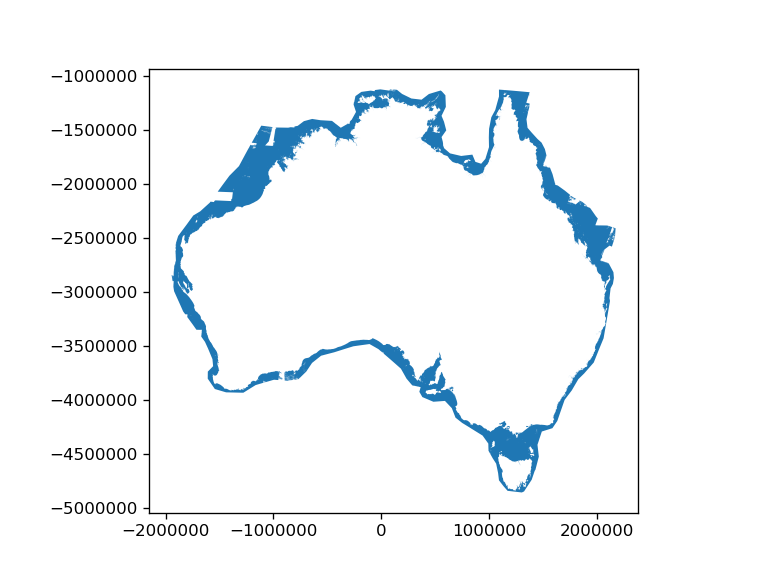

In [13]:
AllTheCoastPolygons.loc[[2], 'geometry'].plot()

In [14]:
# Polygon IDs '1' and '2' are the ocean, and bounding box remainder. We want to delete these.
CleanedUpCoast = AllTheCoastPolygons.drop([1, 2])

In [15]:
CleanedUpCoast.to_file('/g/data/r78/cek156/ShapeFiles/ITEMv2Coastline/ITEMCoastlineCleaned.shp')

## Final clean in QGIS

There are a number of polygons generated as a result of artifacts in the ITEM dataset (like the one highlighted above). In order to clean up those artifacts, we removed any polygons from our ITEM coastline that did not intersect/overlap in some way with a polygons from the OZCOASTS dataset. This may result in some valid island polygons being removed, but is a quick way to quality control the ITEM Coastline polygon set. We did this analysis in QGIS using the `select by location` tool (so we could quickly visually check the results), but it could have been done in python using a spatial join. 

## Final shapefile!

The final high-tide coastline shapefile looks good!

![Shapefile of Australia's high tide coastline](../DocumentationFigures/ITEMAustralianShapefile.JPG)

### Known issues

The known issues identified above in the geotiff file translate also into the shapefile. Landsat 7 scanline corrector issues, as well as some residual data quality issues have resulted in some incorrect polygons being generated. In the image below, showing the southern WA coast, the ITEM-derived hightide coastline in orange is compared to the OZCOASTS 2014 dataset. The erroneous 'land' areas within the ITEM coastline are clearly identifiable. 

![Issues with the shapefile around the southern WA coast](../DocumentationFigures/CoastLimitations.JPG)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** N/A

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)